In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import onset_calculations as onset_calc
import matplotlib.pyplot as plt

In [11]:
OnsetProcessor = onset_calc.OnsetProcessor()

def read_data(select_idx, mode):
    # Feel free to customize this function as per your needs
    
    filelist = os.listdir(f"./Dataset_V2")
    filename = filelist[select_idx]
        
    pickle_path = f'./motion_data_pkl/{filename.replace("_Dancers.csv", "_T.pkl")}'
        
    if os.path.isfile(pickle_path):
        with open(pickle_path, 'rb') as file:
            motion_data = pickle.load(file)

    fname = filename.replace("_Dancers.csv", "_T")
    onset_filename = filename.replace("_Dancers.csv", ".csv")
    danceanno_filename = filename
    mcycle_filename = filename.replace("_Dancers.csv", "_C.csv")

    drum_onsets_path = f"./drum_onsets/{onset_filename}"
    dance_anno_path = f"./Dataset_V2/{danceanno_filename}"
    mcycle_path = f"./virtual_cycles/{mcycle_filename}"

    # Load Djembe drum onsets
    drum_df = pd.read_csv(drum_onsets_path)
    # column_b = drum_df["J2"].dropna()
    # drum_onsets = column_b.to_numpy()

    # Load dance annotations
    dance_annotation_df = pd.read_csv(dance_anno_path)
    category_df = dance_annotation_df.groupby('mocap')
    category_df = category_df.get_group(mode)
    category_df = category_df.reset_index(drop=True)

    # Load meter cycle onsets
    df_metric = pd.read_csv(mcycle_path)
    loaded_mcycle_onsets = df_metric["Virtual Onset"].to_numpy()
    bpm_values = np.round(df_metric["bpm"].to_numpy(), 3)

    section_data = OnsetProcessor.onset_calculations(category_df, loaded_mcycle_onsets)


    return fname, motion_data, drum_df, category_df, df_metric, section_data, bpm_values

### Read data

In [13]:
select_idx = 3      # Choose any idx number (of 47) to access a piece from the file list
mode = "in"         # in: individual dance, gr: group dance, au: dancer in audience
fname, motion_data, drum_df, dance_annotation_df, metric_df, section_data, bpm_values = read_data(select_idx, mode)

### Djembe drum onsets

In [14]:
# Djembe drum onsets: DunDun, Djembe1, Djembe 2
drum_df.head()

,Dun,J1,J2
0,2.271000,0.223000,2.247000
1,2.852333,0.284333,2.577667
2,3.228333,0.492333,2.769667
3,3.724333,0.681667,3.060333
4,4.201667,0.937667,3.249667


### Dance annotation

In [15]:
# Each row is termed as a "Section",
dance_annotation_df

,Start,End,Length,Name,Notes,mocap,Start (in sec),End (in sec),Length (in sec),Part,part time
0,"00:02:14,400","00:02:25,000","00:00:10,600",ht,mocap,in,134.40,145.00,10.60,1,2.271
1,"00:02:58,680","00:03:20,540","00:00:21,860",ht,mocap,in,178.68,200.54,21.86,1,2.271
2,"00:04:13,240","00:04:32,580","00:00:19,340",grf,NaN,in,253.24,272.58,19.34,1,2.271


### Metric cycle

In [16]:
metric_df.head()

,2nd Level m.cycle,J2 Instances,J1 Instances,Dun Instances,Mean J2 Onsets,Mean J1 Onsets,Mean Dun Onsets,Virtual Onset,Parts,Comment,IOI,bpm,Smoothed bpm,cpm
0,2.247000,1,0,1,2.247000,NaN,2.271000,2.259,1.0,NaN,NaN,NaN,NaN,NaN
1,4.201667,1,0,1,4.220333,NaN,4.201667,4.211,NaN,NaN,1.952,122.950820,122.950820,30.737705
2,6.140333,1,0,1,6.129667,NaN,6.140333,6.135,NaN,NaN,1.924,124.740125,123.845472,31.185031
3,8.033667,1,0,1,8.033667,NaN,8.020333,8.027,NaN,NaN,1.892,126.849894,124.846946,31.712474
4,9.911000,1,0,0,9.911000,NaN,NaN,9.911,NaN,m,1.884,127.388535,126.326185,31.847134


### Metadata and onset data

In [ ]:
# This part extracts relevannt data from the dance_annotation_df and metric_df for a section in dance_annotation_df


section_idx = 2  # Replace with the index you need from the dance_annotation_df table

section = section_data[section_idx]
section_name, section_info = list(section.items())[0]

# Access metadata and onset data
section_meta_data = section_info["section_meta_data"]
section_onset_data = section_info["section_onset_data"]

# Unpack metadata
start_timestamp = section_meta_data["start_timestamp"]
end_timestamp = section_meta_data["end_timestamp"]
category = section_meta_data["category"]
start_sec = section_meta_data["start"]
end_sec = section_meta_data["end"]
duration_sec = section_meta_data["duration"]

# Unpack onset data
cycle_onsets = section_onset_data["cycle_onsets"]
total_cycles = section_onset_data["total_blocks"]
cycle_period_list = section_onset_data["cycle_period_list"]
all_window_onsets = section_onset_data["all_window_onsets"]
window_period_list = section_onset_data["window_period_list"]

section_start_idx = np.where(np.isclose(metric_df["Virtual Onset"], cycle_onsets[0], atol=1e-6))[0][0]     # use this index to pull values from other columns (ioi etc)
section_end_idx = np.where(np.isclose(metric_df["Virtual Onset"], cycle_onsets[-1], atol=1e-6))[0][0]      # use this index to pull values from other columns (ioi etc)
section_bpm = metric_df.iloc[section_start_idx+1:section_end_idx+1]["bpm"].to_numpy()          # first bpm value --> cycle_onset[n] & cycle_onsets[n-1]

print("Piece:", fname)
print(f"Section: {section_name}")
print(f"Start (sec): {start_sec}")
print(f"End (sec): {end_sec}")
print(f"Category: {category}")
print(f"Duration (sec): {duration_sec}\n")

print(f"Cycle Onsets: {cycle_onsets}\n")
print(f"Cycle (start, end): {all_window_onsets}\n")    # (start, end) onset of each cycle in original time (seconds)
print(f"Cycle Period List: {cycle_period_list}\n")     # period = end-start
print(f"BPM: {section_bpm}\n")     # period = end-start
print(f"Total Cycles: {total_cycles}\n")

Piece: BKO_E2_D4_01_Suku_T
Section: Section_3
Start (sec): 253.24
End (sec): 272.58
Category: in
Duration (sec): 19.34

Cycle Onsets: [253.73944444 254.79233333 255.83233333 256.84833333 257.87544444
 258.90477778 259.92966667 260.91766667 261.975      263.00433333
 264.04433333 265.04433333 266.071      267.09633333 268.12833333
 269.07011111 270.04566667 271.01855556 272.10166667]

Cycle (start, end): [(253.739, 254.792), (254.792, 255.832), (255.832, 256.848), (256.848, 257.875), (257.875, 258.905), (258.905, 259.93), (259.93, 260.918), (260.918, 261.975), (261.975, 263.004), (263.004, 264.044), (264.044, 265.044), (265.044, 266.071), (266.071, 267.096), (267.096, 268.128), (268.128, 269.07), (269.07, 270.046), (270.046, 271.019), (271.019, 272.102)]

Cycle Period List: [1.05288889 1.04       1.016      1.02711111 1.02933333 1.02488889
 0.988      1.05733333 1.02933333 1.04       1.         1.02666667
 1.02533333 1.032      0.94177778 0.97555556 0.97288889 1.08311111]

BPM: [227.944

### Motion Data

In [26]:
# Segment Names:
# 'SEGMENT_PELVIS', 'SEGMENT_L5', 'SEGMENT_L3', 'SEGMENT_T12', 'SEGMENT_T8', 
# 'SEGMENT_NECK', 'SEGMENT_HEAD', 'SEGMENT_RIGHT_SHOULDER', 'SEGMENT_RIGHT_UPPER_ARM', 
# 'SEGMENT_RIGHT_FOREARM', 'SEGMENT_RIGHT_HAND', 'SEGMENT_LEFT_SHOULDER', 'SEGMENT_LEFT_UPPER_ARM', 
# 'SEGMENT_LEFT_FOREARM', 'SEGMENT_LEFT_HAND', 'SEGMENT_RIGHT_UPPER_LEG', 'SEGMENT_RIGHT_LOWER_LEG', 
# 'SEGMENT_RIGHT_FOOT', 'SEGMENT_RIGHT_TOE', 'SEGMENT_LEFT_UPPER_LEG', 'SEGMENT_LEFT_LOWER_LEG', 
# 'SEGMENT_LEFT_FOOT', 'SEGMENT_LEFT_TOE'

mocap_fps = 240
start_f = np.round(start_sec*mocap_fps).astype(int)     # start frame of the current section
end_f = np.round(end_sec*mocap_fps).astype(int)         # end frame frame of the current section


segment_name = 'SEGMENT_RIGHT_HAND'

# Accessing segment data for the selected section in previous step
position_data = motion_data['position'][segment_name][start_f:end_f,:]                                  # numpy array, size (n,3)
velocity_data = motion_data['velocity'][segment_name][start_f:end_f,:]                                  # numpy array, size (n,3)  
acceleration_data = motion_data['acceleration'][segment_name][start_f:end_f,:]                          # numpy array, size (n,3)
orientation_data = motion_data['orientation'][segment_name][start_f:end_f,:]                          # numpy array, size (n,3)
angular_velocity_data = motion_data['angular_velocity'][segment_name][start_f:end_f,:]                # numpy array, size (n,3)
angular_accelaration_data = motion_data['angular_accelaration'][segment_name][start_f:end_f,:]        # numpy array, size (n,3)
sensor_orientation = motion_data['sensor_orientation'][segment_name][start_f:end_f,:]                 # numpy array, size (n,3)

# Accessing axes data
position_data_X = motion_data['velocity'][segment_name][:,0]    # X-axis, 1d numpy array   
position_data_Y = motion_data['position'][segment_name][:,1]    # Y-axis
position_data_Z = motion_data['position'][segment_name][:,2]    # Z-axis

time_axis = np.arange(len(position_data))/mocap_fps     # for plotting

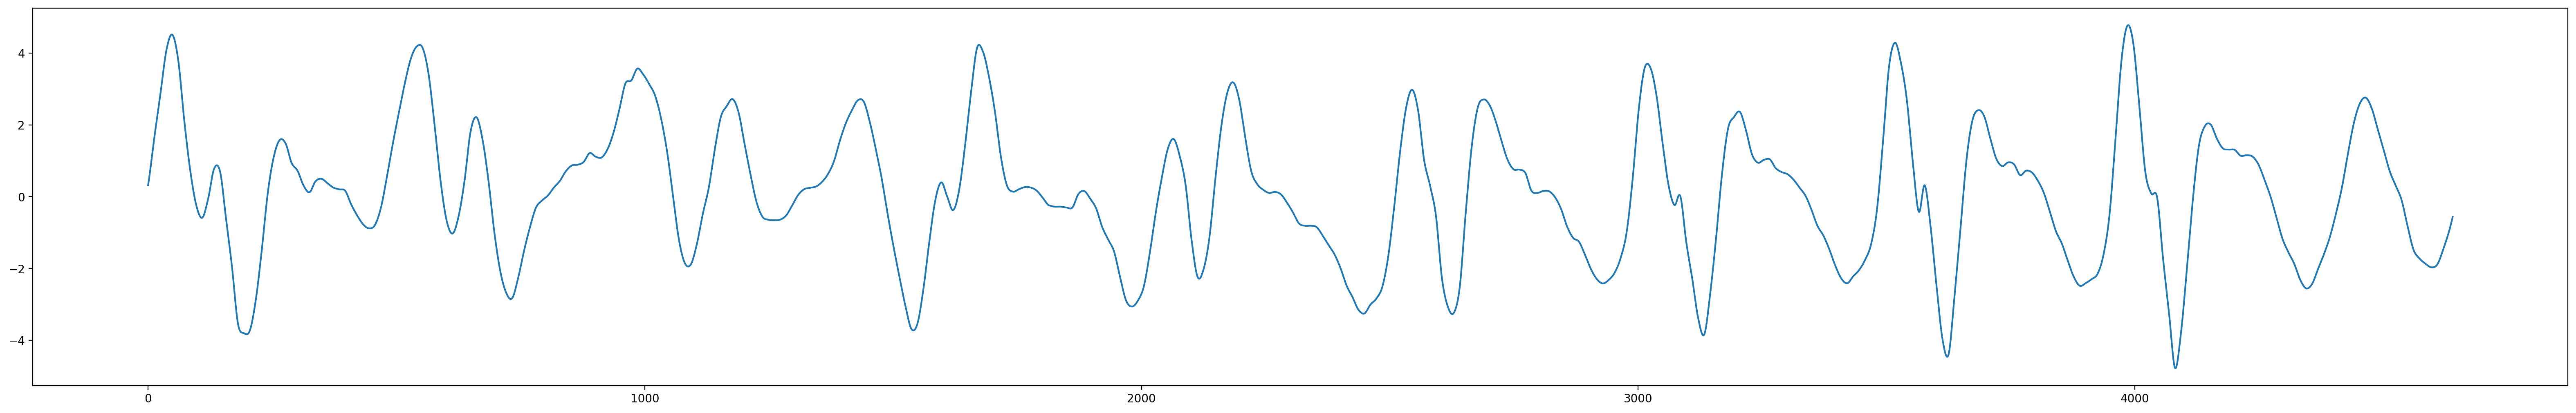

In [27]:
plt.figure(figsize=(40, 6), dpi=200)
plt.plot(position_data_X[start_f:end_f] )

### Load CSV file for the selected piece

In [ ]:
# Example code snippet to load csv files from the results folder

# Change path and filename here to access different onset csv file
feet_onsets_path = f"./extracted_data/{fname}/onset_info/{fname}_both_feet_onsets.csv"
hand_onsets_path = f"./extracted_data/{fname}/onset_info/{fname}_both_hand_onsets.csv"

feet_onset_df = pd.read_csv(feet_onsets_path, usecols=[0])      # onsets from both feet combined
hand_onset_df = pd.read_csv(hand_onsets_path, usecols=[0])      # # onsets from both hand combined

print("Extracted onsets for section", section_idx)
feet_onset_df

### Normalized onsets per cycles for all the sections

In [ ]:
# Loading pickle files from the modes sub folder inside the main piece folder

p= f"./extracted_data/{fname}/{mode}/{fname}_Both_Feet_Onsets_section_cycles.pkl"
with open(p, 'rb') as file:
    c_data = pickle.load(file)

c_data[1]
# Each pickle file when loaded is a list that contains a list of arrays for each section, with each array representing the normalized onsets for a cycle.
# c_data[0] is for section 1
# c_data[1] is for section 2, and so on

### Calculate beat onsets

In [ ]:
def calculate_beat_onsets(cycle_onsets):
        beat_ref = []
        for i in range(len(cycle_onsets) - 1):
            start = cycle_onsets[i]
            end = cycle_onsets[i + 1]
            # Generate beat onsets by dividing the interval into 4 equal parts
            beat_onsets = np.linspace(start, end, num=5)[:-1]
            beat_ref.extend(beat_onsets)
        return np.round(np.array(beat_ref), 3)
    
beat_ref = calculate_beat_onsets(cycle_onsets)
beat_ref
(253.751, 254.783)

array([253.751, 254.009, 254.267, 254.525, 254.783, 255.043, 255.303,
       255.563, 255.823, 256.082, 256.341, 256.599, 256.858, 257.115,
       257.372, 257.63 , 257.887, 258.143, 258.399, 258.655, 258.911,
       259.163, 259.415, 259.667, 259.919, 260.172, 260.426, 260.679,
       260.932, 261.193, 261.454, 261.714, 261.975, 262.232, 262.49 ,
       262.747, 263.004, 263.264, 263.524, 263.784, 264.044, 264.297,
       264.549, 264.802, 265.055, 265.31 , 265.564, 265.819, 266.074,
       266.332, 266.59 , 266.848, 267.106, 267.358, 267.611, 267.864,
       268.116, 268.356, 268.595, 268.834, 269.074, 269.317, 269.561,
       269.804, 270.047, 270.294, 270.54 , 270.787, 271.034, 271.299,
       271.564, 271.83 ])